In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1,), (0.3,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


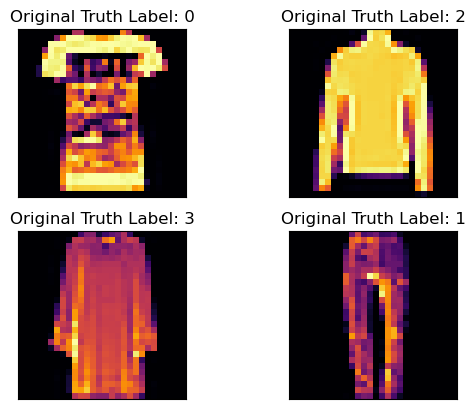

In [4]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Original Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()